In [1]:
# size of mote carlo sampling
sampSize = 10

In [2]:
%%time
from pycolator import *

idCol = 'SpecId'
scoreCol = 'NuXL:score'
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'class-specific_q-val', 'Rank', 'temp_score', 'percolator_score']

dSlow = readAndProcess('../data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol, excludedCols = excluded)
features = [x for x in list(dSlow.columns) if (x not in excluded)]

file read...
strings converted to floats...
q-values estimated...
ranks computed...
features normed...
floats converted to ints...
file ready!
Wall time: 17.6 s


In [3]:
# set up metrics of original data set

oriIdents = []
oriExpectIdents = []
oriLen = []
oriAUCs = []
oriAUCNorm = []
oriIdentsNorm = []
oriLenNorm = []
dxl = dSlow.loc[dSlow['NuXL:isXL'] == 1].copy()
dxl = addRanks(dxl, 'SpecId', 'NuXL:score')
    
for i in range(sampSize):
    expIdTemp = []
    lenTemp = []
    idTemp = []
    aucTemp = []
    aucnormTemp = []
    idnormTemp = []
    lennormTemp = []
    for portion in range(12): # smallest df has 3 entries
        newDf = dxl.loc[dxl['class-specific_q-val'] <= 0.1].sample(frac = 1/pow(2,portion))
        expIdTemp.append(len(newDf.loc[newDf['class-specific_q-val'] <= 0.01]))
        
        newDf = calcQ(newDf, 'NuXL:score')
        try:
            aucTemp.append(pseudoROC(newDf, plot = False))
        except:
            aucTemp.append(0.0)
        try:
            aucnormTemp.append(pseudoROC(newDf.loc[newDf.Rank == 1], plot = False))
        except:
            aucnormTemp.append(0.0)
        lenTemp.append(len(newDf))
        lennormTemp.append(len(newDf.loc[newDf.Rank == 1]))
        idTemp.append(len(newDf.loc[newDf['q-val'] <= 0.01]))
        idnormTemp.append(len(newDf.loc[(newDf['q-val'] <= 0.01) & (newDf.Rank == 1)]))
    oriExpectIdents.append(expIdTemp)
    oriLen.append(lenTemp)
    oriIdents.append(idTemp)
    oriAUCs.append(aucTemp)
    oriAUCNorm.append(aucnormTemp)
    oriIdentsNorm.append(idnormTemp)
    oriLenNorm.append(lennormTemp)

In [17]:
print(list(zip([(min(i), max(i)) for i in zip(*oriLenNorm)], [(min(i), max(i)) for i in zip(*pLen)])))

[((4833, 4833), (4833, 4833)), ((2384, 2444), (2692, 2724)), ((1186, 1221), (1408, 1436)), ((585, 619), (726, 734)), ((284, 311), (367, 372)), ((145, 159), (185, 187)), ((72, 79), (92, 93))]


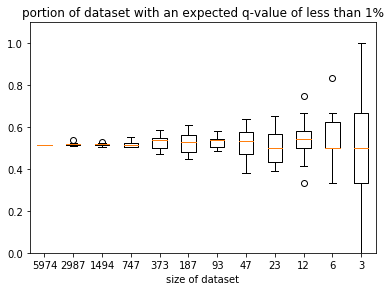

In [5]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_ylim(0,1.1)
x = range(1,13)

# for every sample round, for every dataset size, divide number of expected idents by the dataset size
l = [[e/l for e,l in zip(es,ls)] for es,ls in zip(oriExpectIdents,oriLen)]
# transpose for boxplots
y = list(map(list, zip(*l)))

ax.boxplot(y)
ax.set_xlabel('size of dataset')
ax.set_title('portion of dataset with an expected q-value of less than 1%')
ax.set_xticks(x)
ax.set_xticklabels(oriLen[0])
plt.savefig('../results/ratioTests/boxplots/result_splitting_dxl.png')
plt.show()

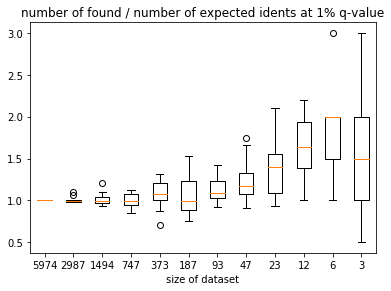

In [6]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
x = range(1,13)

# for every sample round, for every dataset size, divide number of idents by the number of expected idents, or 1 if we expect 0
l = [[i/e if (e != 0) else np.nan for i,e in zip(ils,es)] for ils,es in zip(oriIdents,oriExpectIdents)]
# transpose for boxplots
y = list(map(list, zip(*l)))
# remove nan for boxplot
y = [[i for i in ls if not np.isnan(i)] for ls in y]

ax.boxplot(y)
ax.set_xlabel('size of dataset')
ax.set_title('number of found / number of expected idents at 1% q-value')
ax.set_xticks(x)
ax.set_xticklabels(oriLen[0])
plt.savefig('../results/ratioTests/boxplots/found_vs_expected_dxl.png')
plt.show()

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2966, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3143, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3347, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.7416568991085.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3350, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3352, length of negative training set: 398
Optimal parameters are C=1 and class_w

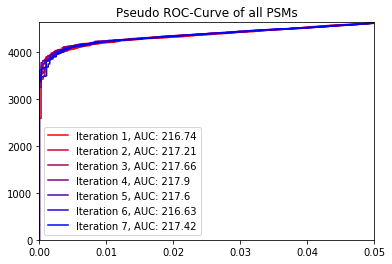

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1479, length of negative training set: 195
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1583, length of negative training set: 195
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1676, length of negative training set: 196
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.46458824058013.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1665, length of negative training set: 195
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1674, length of negative training set: 195
Optimal parameters are C=10 an

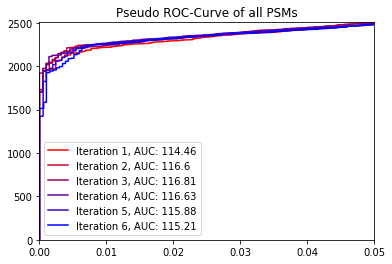

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 755, length of negative training set: 106
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 787, length of negative training set: 107
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 833, length of negative training set: 107
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 58.65416431310965.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 837, length of negative training set: 106
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 831, length of negative training set: 107
Optimal parameters are C=10 and class_weigh

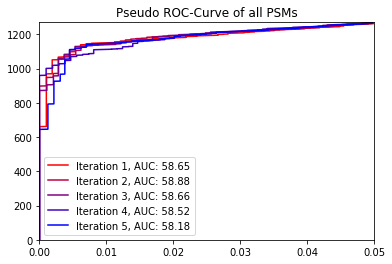

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 370, length of negative training set: 52
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 397, length of negative training set: 53
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 418, length of negative training set: 53
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 29.06596203342934.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 413, length of negative training set: 52
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 422, length of negative training set: 53
Optimal parameters are C=1 and class_weight={0: 1

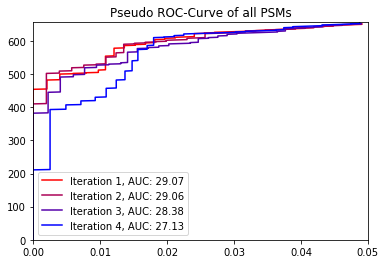

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 181, length of negative training set: 26
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 202, length of negative training set: 26
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 214, length of negative training set: 26
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.616012545615877.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 214, length of negative training set: 26
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 212, length of negative training set: 26
Optimal parameters are C=0.1 and class_we

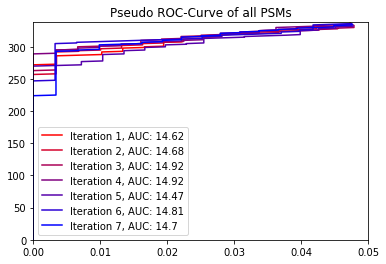

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 88, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 91, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 107, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.146933944462028.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 109, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 106, length of negative training set: 13
Optimal parameters are C=0.1 and class_weight=

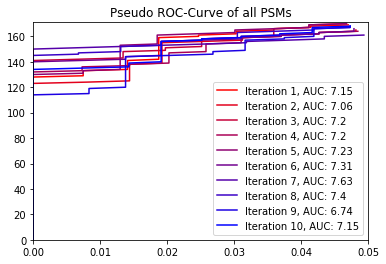

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 42, length of negative training set: 11
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 44, length of negative training set: 11
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 45, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.7003607503607476.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 43, length of negative training set: 11
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 41, length of negative training set: 11
Optimal parameters are C=0.1 and class_weight=

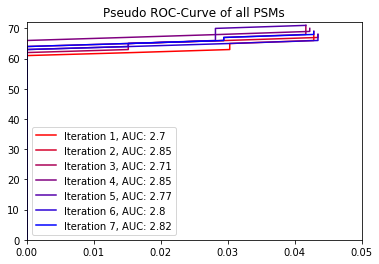

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2974, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3148, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3354, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.51553721349674.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3368, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3350, length of negative trai

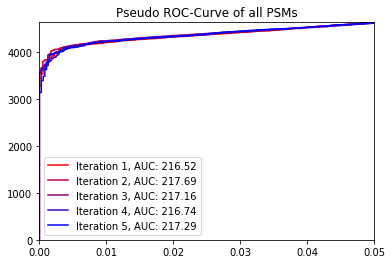

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1500, length of negative training set: 189
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1582, length of negative training set: 189
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1692, length of negative training set: 190
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.60536887328671.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1690, length of negative training set: 189
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1679, length of negative training set: 189
Optimal parameters are C=1 an

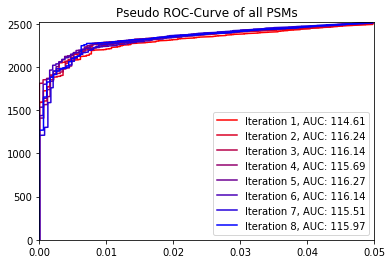

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 751, length of negative training set: 96
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 791, length of negative training set: 97
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 843, length of negative training set: 97
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 59.36634112760847.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 840, length of negative training set: 96
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 847, length of negative training set: 97
Optimal parameters are C=0.1 and class_weight

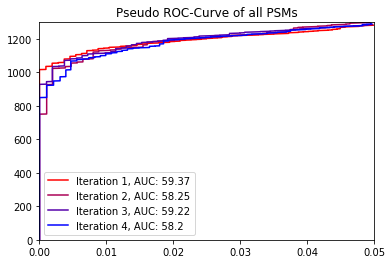

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 360, length of negative training set: 56
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 378, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 422, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 29.9764706936386.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 412, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 414, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0:

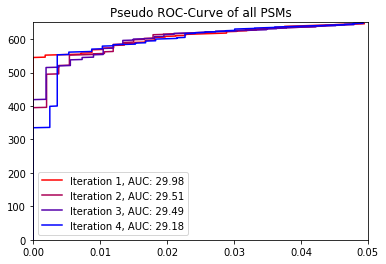

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 188, length of negative training set: 23
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 198, length of negative training set: 23
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 209, length of negative training set: 24
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.31051942344681.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 214, length of negative training set: 23
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 204, length of negative training set: 23
Optimal parameters are C=0.1 and class_weight

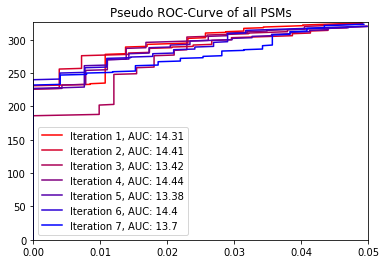

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 96, length of negative training set: 8
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 108, length of negative training set: 9
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 114, length of negative training set: 9
Optimal parameters are C=10 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.235758151347346.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 109, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 111, length of negative training set: 9
Optimal parameters are C=0.1 and class_weight={

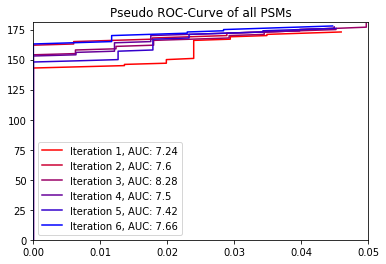

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 40, length of negative training set: 10
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 39, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 42, length of negative training set: 10
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.705790043290041.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 44, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 47, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0:

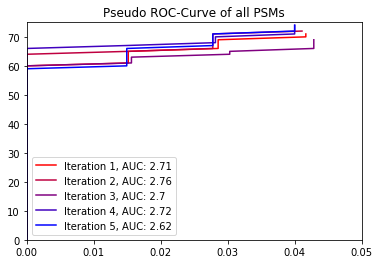

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2976, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3163, length of negative training set: 398
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3338, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 217.6307329625405.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3357, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3336, length of negative trai

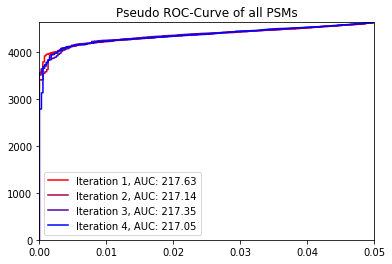

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1501, length of negative training set: 200
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1599, length of negative training set: 200
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1673, length of negative training set: 200
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.13319822190657.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1658, length of negative training set: 200
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1676, length of negative training set: 200
Optimal parameters are C=1 and c

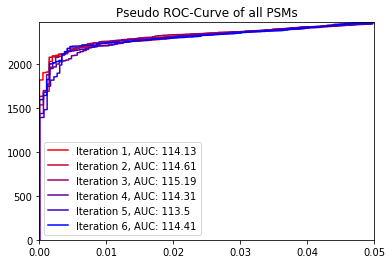

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 737, length of negative training set: 104
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 779, length of negative training set: 104
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 831, length of negative training set: 104
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 58.118872654533405.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 831, length of negative training set: 104
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 828, length of negative training set: 104
Optimal parameters are C=10 and class_we

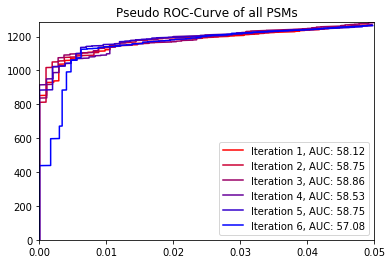

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 368, length of negative training set: 47
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 398, length of negative training set: 47
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 437, length of negative training set: 48
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 28.901037547758524.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 433, length of negative training set: 47
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 431, length of negative training set: 47
Optimal parameters are C=1 and class_weight

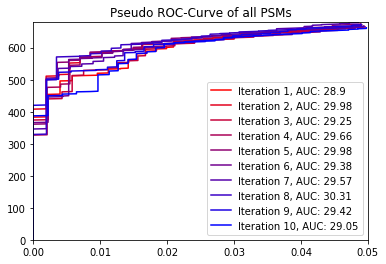

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 190, length of negative training set: 26
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 197, length of negative training set: 26
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 203, length of negative training set: 26
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.420997484279225.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 207, length of negative training set: 26
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 209, length of negative training set: 26
Optimal parameters are C=10 and class_weight=

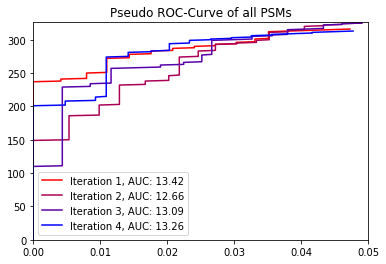

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 98, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 104, length of negative training set: 13
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 101, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.043162642752825.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 106, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 104, length of negative training set: 13
Optimal parameters are C=10 and class_weigh

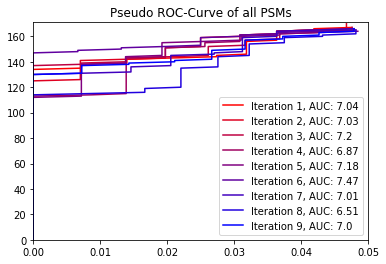

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 42, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 50, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 49, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.860590132309672.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 49, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 48, length of negative training set: 7
Optimal parameters are C=1 and class_weight={0: 10

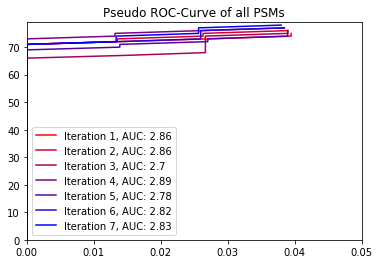

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 24, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 22, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 19, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 0.9166666666666665.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 18, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 21, length of negative training set: 3
Optimal parameters are C=1 and class_weight={0: 3,

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Iteration 2/10 done! It yielded an auc of 1.7498436522826784.

Training in iteration 3 with split 1/3 starts!
Length of positive trainingset: 27, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 3 with split 2/3 starts!
Length of positive trainingset: 22, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 3 with split 3/3 starts!
Length of positive trainingset: 17, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Iteration 3/10 done! It yielded an auc of 0.8714285714285717.

Re-ranking complete. Cutting off low ranks.

Training in iteration 4 with split 1/3 starts!
Length of positive trainingset: 20, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 4 with split 2/3 starts!
Lengt

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 4 with split 3/3 starts!
Length of positive trainingset: 23, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Iteration 4/10 done! It yielded an auc of 1.782051282051284.

Training in iteration 5 with split 1/3 starts!
Length of positive trainingset: 23, length of negative training set: 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 5 with split 2/3 starts!
Length of positive trainingset: 20, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 5 with split 3/3 starts!
Length of positive trainingset: 19, length of negative training set: 4
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Iteration 5/10 done! It yielded an auc of 0.9242424242424234.

Training in iteration 6 with split 1/3 starts!
Length of positive trainingset: 20, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 6 with split 2/3 starts!
Length of positive trainingset: 18, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 6 with split 3/3 starts!
Length of positive trainingset: 15, length of negative training set: 4
Optimal parameters are C=0.1 and class_wei

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Iteration 7/10 done! It yielded an auc of 1.7242026266416526.

Results are not getting better. Terminating and using Iteration 4 with an auc of 1.78.


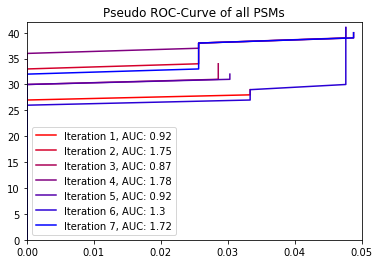

Dataset too small: 23 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2993, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3140, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3350, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 215.74478430576346.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3361, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3367, length of negative trai

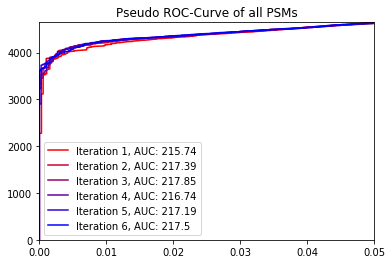

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1489, length of negative training set: 208
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1568, length of negative training set: 209
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1624, length of negative training set: 209
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 112.72369127910687.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1649, length of negative training set: 208
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1641, length of negative training set: 209
Optimal parameters are C=1 and

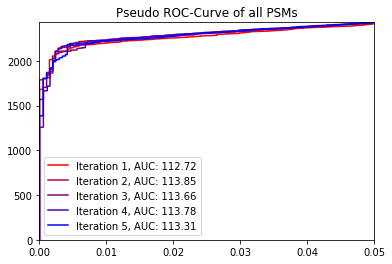

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 739, length of negative training set: 96
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 776, length of negative training set: 96
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 834, length of negative training set: 96
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 58.44016269576392.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 824, length of negative training set: 96
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 832, length of negative training set: 96
Optimal parameters are C=0.1 and class_weight={0:

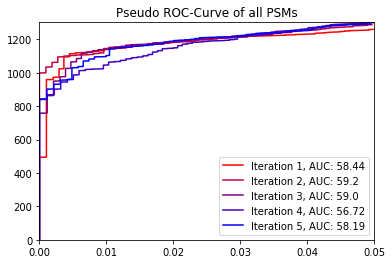

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 366, length of negative training set: 48
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 392, length of negative training set: 49
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 425, length of negative training set: 49
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 30.238968013169803.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 428, length of negative training set: 48
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 432, length of negative training set: 49
Optimal parameters are C=1 and class_weight=

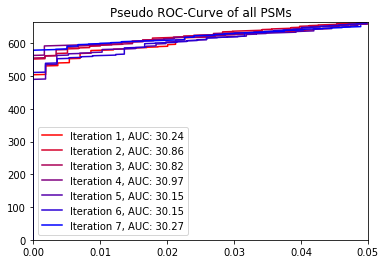

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 189, length of negative training set: 31
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 191, length of negative training set: 31
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 195, length of negative training set: 32
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.816854978839963.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 200, length of negative training set: 31
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 198, length of negative training set: 31
Optimal parameters are C=10 and class_weigh

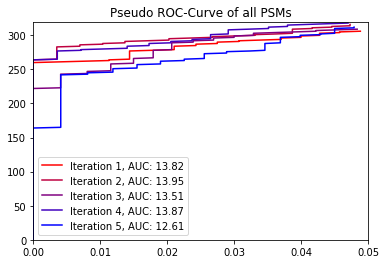

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 94, length of negative training set: 12
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 99, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 100, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.024501313903161.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 102, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 104, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight

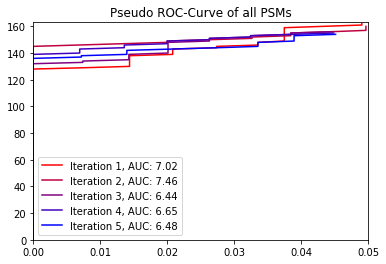

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 45, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 51, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 54, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.8539341194951477.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 53, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 52, length of negative training set: 5
Optimal parameters are C=10 and class_weight={0: 1

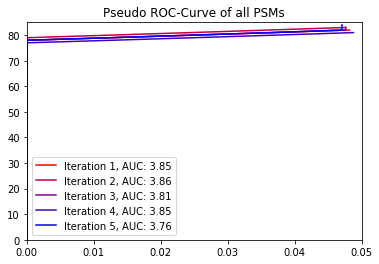

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2976, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3132, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3336, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.13333830411548.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3355, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3349, length of negative train

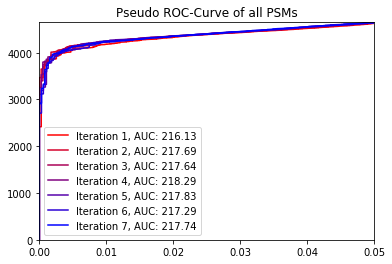

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1494, length of negative training set: 204
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1584, length of negative training set: 204
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1693, length of negative training set: 204
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 117.93240190396845.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1691, length of negative training set: 204
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1679, length of negative training set: 204
Optimal parameters are C=10 and 

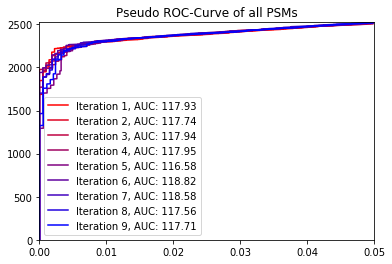

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 766, length of negative training set: 99
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 792, length of negative training set: 99
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 820, length of negative training set: 100
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 57.62786528374694.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 832, length of negative training set: 99
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 837, length of negative training set: 99
Optimal parameters are C=10 and class_weight={0:

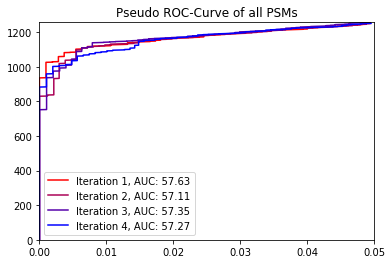

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 377, length of negative training set: 46
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 405, length of negative training set: 46
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 427, length of negative training set: 46
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 27.44513158803125.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 426, length of negative training set: 46
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 424, length of negative training set: 46
Optimal parameters are C=1 and class_weight={0: 

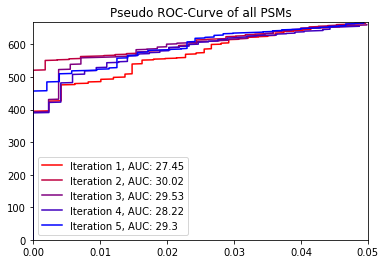

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 198, length of negative training set: 23
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 199, length of negative training set: 23
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 203, length of negative training set: 24
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 15.246498636596495.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 205, length of negative training set: 23
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 210, length of negative training set: 23
Optimal parameters are C=0.1 and class_

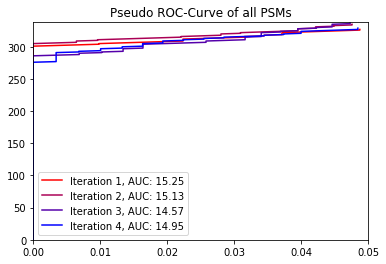

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 88, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 94, length of negative training set: 11
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 101, length of negative training set: 11
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.179075809628553.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 104, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 103, length of negative training set: 11
Optimal parameters are C=0.1 and class_weight

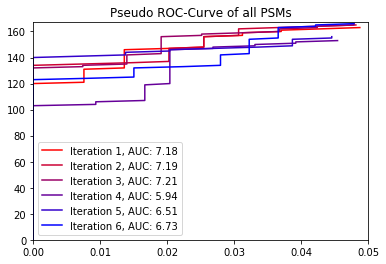

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 40, length of negative training set: 8
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 38, length of negative training set: 9
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 43, length of negative training set: 9
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.7595850840336107.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 43, length of negative training set: 8
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 48, length of negative training set: 9
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}

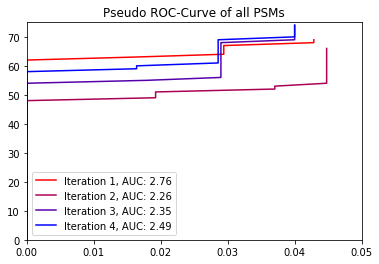

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2982, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3181, length of negative training set: 398
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3337, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.0659777758621.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3333, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3367, length of negative trai

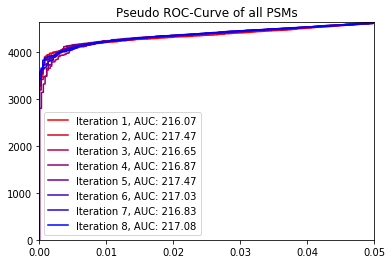

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1488, length of negative training set: 197
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1579, length of negative training set: 197
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1673, length of negative training set: 198
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 112.49374964408334.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1672, length of negative training set: 197
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1677, length of negative training set: 197
Optimal parameters are C=10 a

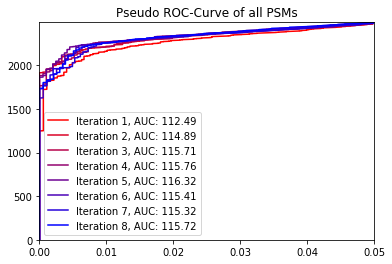

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 749, length of negative training set: 92
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 804, length of negative training set: 93
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 856, length of negative training set: 93
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 60.70593650216613.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 855, length of negative training set: 92
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 851, length of negative training set: 93
Optimal parameters are C=10 and class_weight

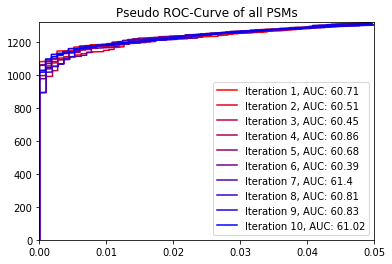

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 376, length of negative training set: 57
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 386, length of negative training set: 57
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 400, length of negative training set: 58
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 28.646333821789543.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 404, length of negative training set: 57
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 410, length of negative training set: 57
Optimal parameters are C=1 and class_weight={0:

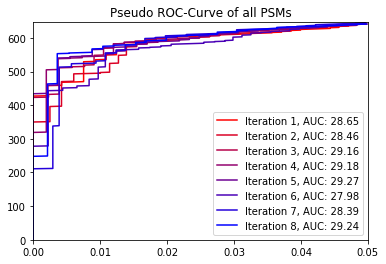

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 184, length of negative training set: 27
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 192, length of negative training set: 27
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 189, length of negative training set: 28
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.422286711541762.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 189, length of negative training set: 27
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 196, length of negative training set: 27
Optimal parameters are C=1 and class_weight

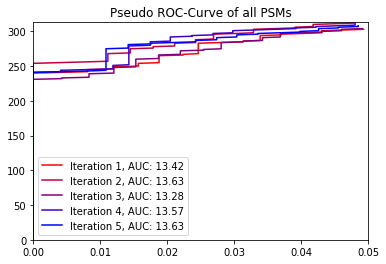

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 95, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 97, length of negative training set: 13
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 100, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 6.853941561568073.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 104, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 97, length of negative training set: 13
Optimal parameters are C=0.1 and class_weight={

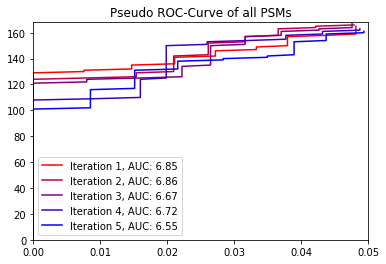

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 50, length of negative training set: 6
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 52, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 54, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.6794812592638086.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 53, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 55, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 1

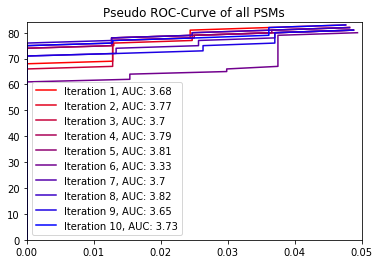

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2970, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3132, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3372, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.91942692234002.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3354, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3359, length of negative traini

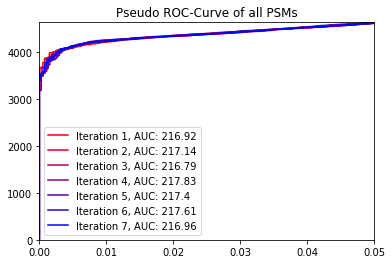

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1496, length of negative training set: 212
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1574, length of negative training set: 213
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1670, length of negative training set: 213
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.6937231065648.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1662, length of negative training set: 212
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1672, length of negative training set: 213
Optimal parameters are C=1 an

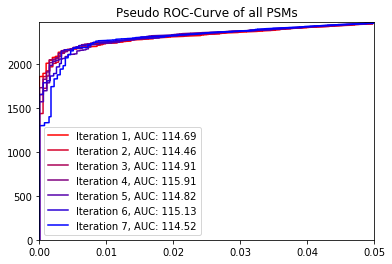

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 750, length of negative training set: 110
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 801, length of negative training set: 110
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 820, length of negative training set: 110
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 59.10347050765553.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 826, length of negative training set: 110
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 826, length of negative training set: 110
Optimal parameters are C=1 and class_weight

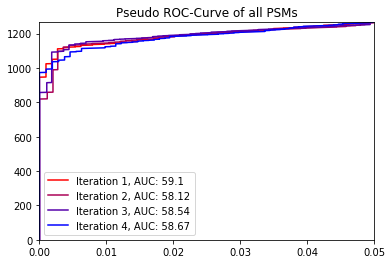

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 371, length of negative training set: 45
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 398, length of negative training set: 45
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 427, length of negative training set: 46
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 30.09540304690896.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 422, length of negative training set: 45
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 422, length of negative training set: 45
Optimal parameters are C=10 and class_weight={0

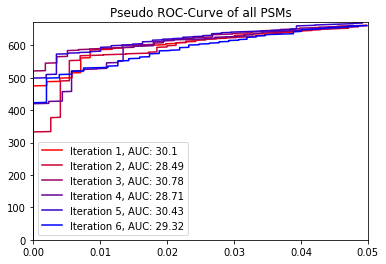

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 184, length of negative training set: 28
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 199, length of negative training set: 28
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 207, length of negative training set: 28
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.113367602324981.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 207, length of negative training set: 28
Optimal parameters are C=10 and class_weight={0: 10, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 210, length of negative training set: 28
Optimal parameters are C=10 and class_weight

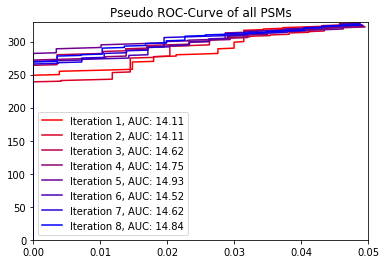

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 95, length of negative training set: 14
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 93, length of negative training set: 14
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 94, length of negative training set: 14
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 6.537332052169037.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 101, length of negative training set: 14
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 97, length of negative training set: 14
Optimal parameters are C=1 and class_weight={0: 

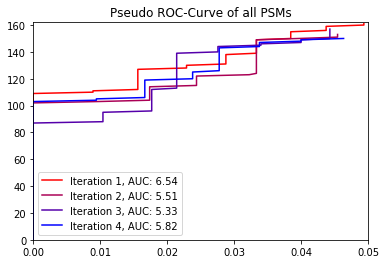

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 48, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 46, length of negative training set: 9
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 50, length of negative training set: 9
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.0932084003678924.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 48, length of negative training set: 8
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 46, length of negative training set: 9
Optimal parameters are C=1 and class_weight={0: 10, 1:

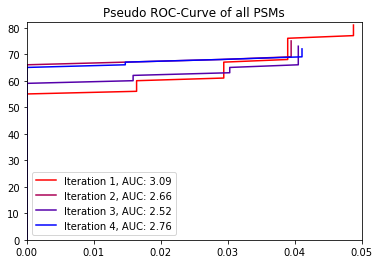

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 22, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 15, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 14, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 0.8870967741935476.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 19, length of negative training set: 3
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 22, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1,

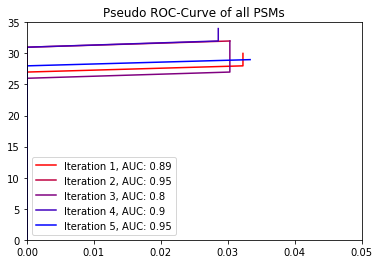

Dataset too small: 23 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2998, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3149, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3348, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.74071138241814.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3343, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3347, length of negative trai

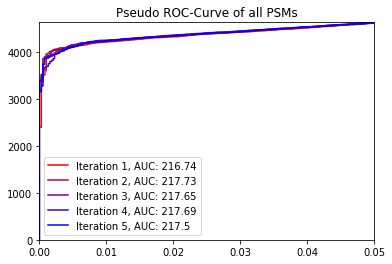

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1500, length of negative training set: 193
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1610, length of negative training set: 193
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1673, length of negative training set: 194
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.96505835752018.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1681, length of negative training set: 193
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1683, length of negative training set: 193
Optimal parameters are C=0

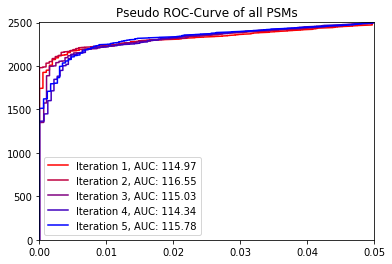

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 734, length of negative training set: 102
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 788, length of negative training set: 103
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 854, length of negative training set: 103
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 58.392297269519034.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 848, length of negative training set: 102
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 841, length of negative training set: 103
Optimal parameters are C=10 and class_w

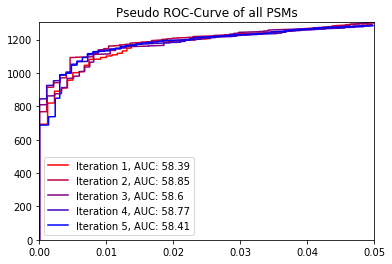

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 376, length of negative training set: 51
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 405, length of negative training set: 51
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 432, length of negative training set: 52
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 28.769731071856683.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 426, length of negative training set: 51
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 427, length of negative training set: 51
Optimal parameters are C=0.1 and class_weight={

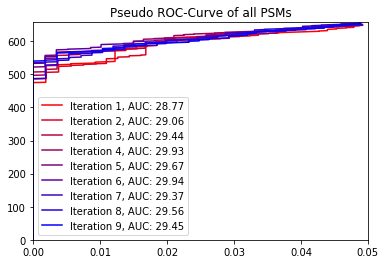

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 178, length of negative training set: 28
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 189, length of negative training set: 28
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 199, length of negative training set: 28
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 12.946113572925475.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 200, length of negative training set: 28
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 206, length of negative training set: 28
Optimal parameters are C=0.1 and class_wei

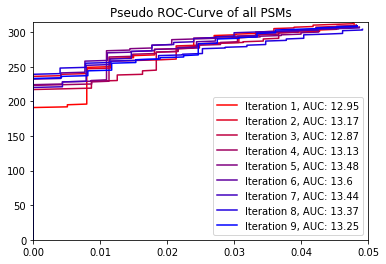

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 93, length of negative training set: 12
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 102, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 100, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.1201226182925295.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 105, length of negative training set: 12
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 104, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0:

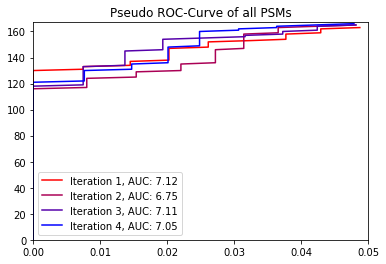

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 47, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 50, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 57, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.7721542337218974.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 55, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 51, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 1,

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 3 with split 2/3 starts!
Length of positive trainingset: 52, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 3 with split 3/3 starts!
Length of positive trainingset: 57, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Iteration 3/10 done! It yielded an auc of 3.4364365706757054.

Training in iteration 4 with split 1/3 starts!
Length of positive trainingset: 54, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 4 with split 2/3 starts!
Length of positive trainingset: 49, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 4 with split 3/3 starts!
Length of positive trainingset: 50, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight

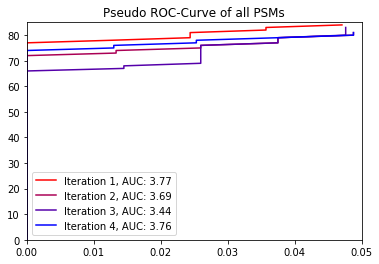

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2980, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3171, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3346, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 217.1592211288993.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3351, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3370, length of negative trainin

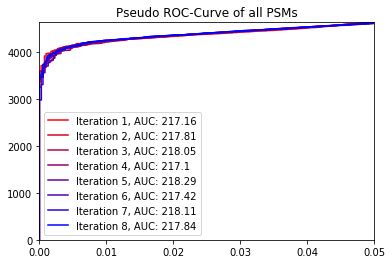

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1488, length of negative training set: 208
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1575, length of negative training set: 208
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1656, length of negative training set: 208
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.99763749503046.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1658, length of negative training set: 208
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1674, length of negative training set: 208
Optimal parameters are C=1 an

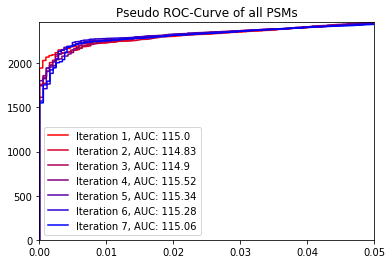

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 744, length of negative training set: 96
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 790, length of negative training set: 97
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 837, length of negative training set: 97
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 59.24443905749517.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 828, length of negative training set: 96
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 833, length of negative training set: 97
Optimal parameters are C=1 and class_weight={0

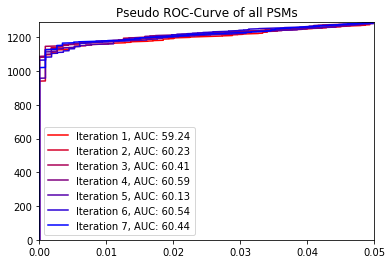

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 371, length of negative training set: 48
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 397, length of negative training set: 48
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 402, length of negative training set: 48
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 29.065821242358822.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 407, length of negative training set: 48
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 411, length of negative training set: 48
Optimal parameters are C=0.1 and class_weigh

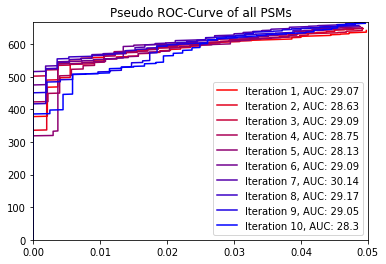

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 181, length of negative training set: 24
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 193, length of negative training set: 24
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 209, length of negative training set: 24
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.63844941709545.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 211, length of negative training set: 24
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 217, length of negative training set: 24
Optimal parameters are C=0.1 and class_weight

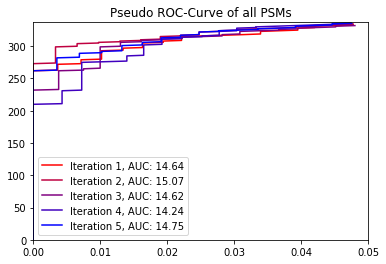

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 88, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 94, length of negative training set: 11
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 104, length of negative training set: 11
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.237846725479139.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 106, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 106, length of negative training set: 11
Optimal parameters are C=0.1 and class_weig

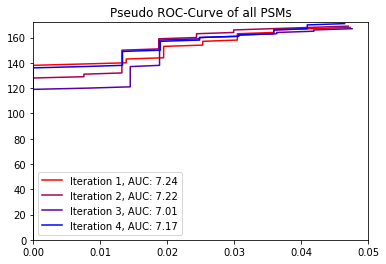

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 51, length of negative training set: 3
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 56, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 59, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.721162895075936.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 58, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 59, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 

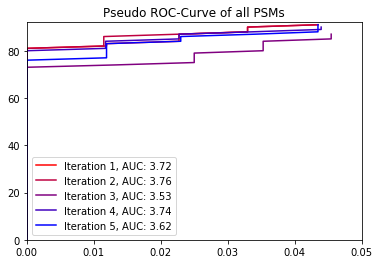

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 22, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 19, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 24, length of negative training set: 4
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 0.9324324324324306.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 23, length of negative training set: 4
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 26, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 

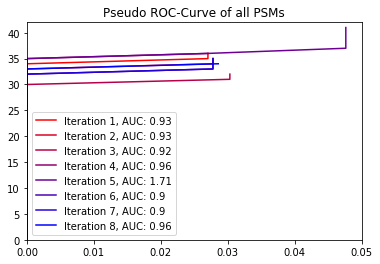

Dataset too small: 23 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2954, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3172, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3334, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.12417976742492.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3357, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3356, length of negative train

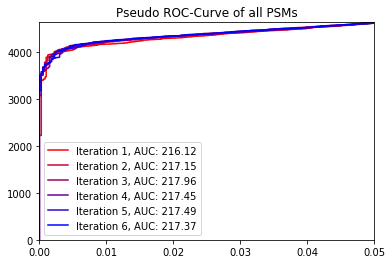

False
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1471, length of negative training set: 208
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1575, length of negative training set: 208
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1664, length of negative training set: 208
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 115.92772975201706.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1666, length of negative training set: 208
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1665, length of negative training set: 208
Optimal parameters are C=10 and

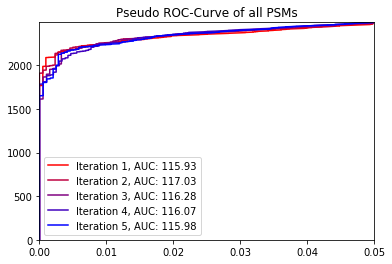

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 739, length of negative training set: 101
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 790, length of negative training set: 101
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 827, length of negative training set: 102
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 57.732275471915194.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 830, length of negative training set: 101
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 851, length of negative training set: 101
Optimal parameters are C=1 and class_weight

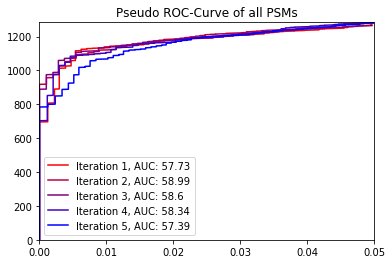

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 366, length of negative training set: 49
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 396, length of negative training set: 49
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 421, length of negative training set: 50
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 28.646215401903905.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 417, length of negative training set: 49
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 417, length of negative training set: 49
Optimal parameters are C=1 and class_weight={0

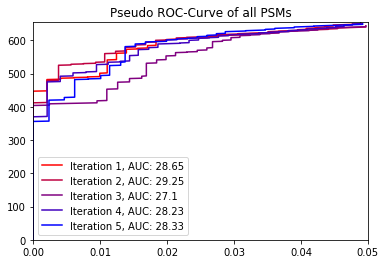

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 183, length of negative training set: 33
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 188, length of negative training set: 33
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 191, length of negative training set: 34
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.399023335477413.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 194, length of negative training set: 33
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 196, length of negative training set: 33
Optimal parameters are C=0.1 and class_weight=

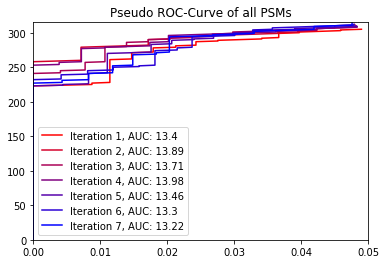

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 90, length of negative training set: 14
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 91, length of negative training set: 14
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 99, length of negative training set: 14
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.3208735344287295.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 102, length of negative training set: 14
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 106, length of negative training set: 14
Optimal parameters are C=0.1 and class_weight=

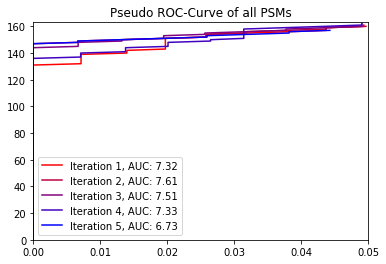

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 49, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 48, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 52, length of negative training set: 8
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.6310509807939715.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 45, length of negative training set: 7
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 49, length of negative training set: 7
Optimal parameters are C=1 and class_weight={0: 3, 1:

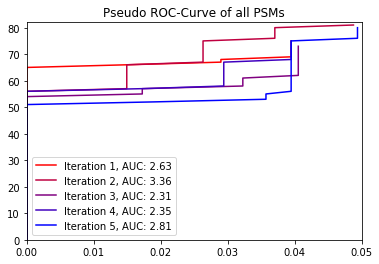

Dataset too small: 47 PSMs. Quitting evaluation.
Wall time: 8min 3s


In [7]:
%%time
# calculate metrics of percolator results

# expected idents if algorithm would work as well as NuXL:score
expId = []

# expected idents if the algorithm would work as well as with the whole data set
pExpectIdents = []

pIdents = []
pLen = []
pAUCs = []

# With which portion the algorithm terminated
pAbort = []

saveName = ''

iters = 12 # smallest df has 3 entries
for i in range(sampSize):
    stdExpIdTemp = []
    expIdTemp = []
    idTemp = []
    lenTemp = []
    aucTemp = []
    
    for portion in range(iters):
        dxl = dSlow.loc[dSlow['NuXL:isXL'] == 1].copy()
        dxl = addRanks(dxl, 'SpecId', 'NuXL:score')

        newDf = dxl.loc[dxl['class-specific_q-val'] <= 0.1].sample(frac = 1/pow(2,portion))
        stdExpIdTemp.append(len(newDf.loc[(newDf['class-specific_q-val'] <= 0.01) & (newDf['Rank'] == 1)]))
        newIx = newDf.index

        try:
            pxl = percolator_experimental(newDf, idCol, features, plotSaveName = saveName, plotXLnXL = False)
        except:
            print('Dataset too small: {} PSMs. Quitting evaluation.'.format(len(newDf)))
            del stdExpIdTemp[-1]
            break

        if (portion == 0):
            print(all(pxl['q-val'] == pxl['class-specific_q-val']))
            fullP = pxl.loc[:,['Label', 'percolator_score', 'q-val']].copy()

        # maybe calc Q with sampled subset of fullP?
        expIdTemp.append(len(fullP.loc[(fullP.index.isin(newIx)) & (fullP['q-val'] <= 0.01)]))

        try:
            aucTemp.append(pseudoROC(pxl, plot = False))
        except:
            print('Error while calculating AUC in iteration {}/{}!'.format(portion + 1, iters))
            aucTemp.append(0.0)
        lenTemp.append(len(pxl))
        idTemp.append(len(pxl.loc[pxl['q-val'] <= 0.01]))
        
    pAbort.append(portion)
    expId.append(stdExpIdTemp)
    pExpectIdents.append(expIdTemp)
    pLen.append(lenTemp)
    pIdents.append(idTemp)
    pAUCs.append(aucTemp)

In [12]:
[(min(i), max(i)) for i in zip(*pLen)]

[(4833, 4833),
 (2692, 2724),
 (1408, 1436),
 (726, 734),
 (367, 372),
 (185, 187),
 (92, 93)]

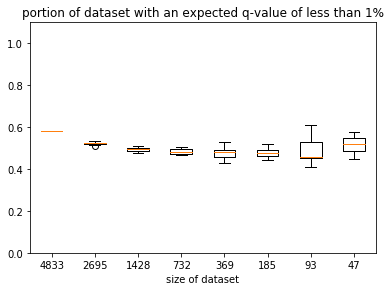

In [8]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_ylim(0,1.1)
x = range(1,max(pAbort) + 1)

# for every sample round, for every dataset size, divide number of expected idents by the dataset size
l = [[e/l for e,l in zip(es,ls)] for es,ls in zip(expId,pLen)]
# for missing iterations, fill in nan
for k in l:
    while(len(k) != max(pAbort)):
        k.append(np.nan)
# transpose for boxplots
y = list(map(list, zip(*l)))
# filter nan for boxplot
y = [[i for i in ls if not np.isnan(i)] for ls in y]

ax.boxplot(y)
ax.set_xlabel('size of dataset')
ax.set_title('portion of dataset with an expected q-value of less than 1%')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/result_splitting_pxl.png')
plt.show()

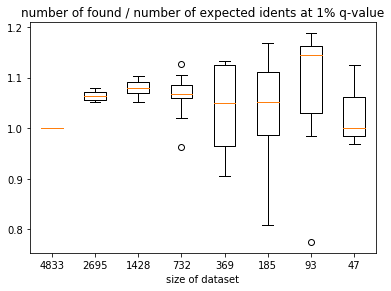

In [9]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
x = range(1,max(pAbort) + 1)

# for every sample round, for every dataset size, divide number of idents by the number of expected idents, or 1 if we expect 0
l = [[i/e if (e != 0) else np.nan for i,e in zip(ils,es)] for ils,es in zip(pIdents,pExpectIdents)]
# for missing iterations, fill in nan
for k in l:
    while(len(k) != max(pAbort)):
        k.append(np.nan)
# transpose for boxplots
y = list(map(list, zip(*l)))
# remove nan for boxplot
y = [[i for i in ls if not np.isnan(i)] for ls in y]

ax.boxplot(y)
ax.set_xlabel('size of dataset')
ax.set_title('number of found / number of expected idents at 1% q-value')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/found_vs_expected_pxl.png')
plt.show()

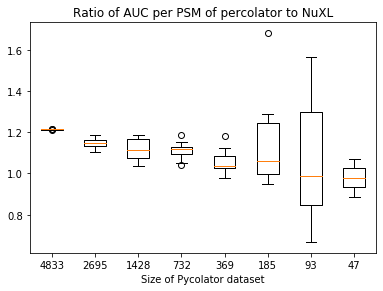

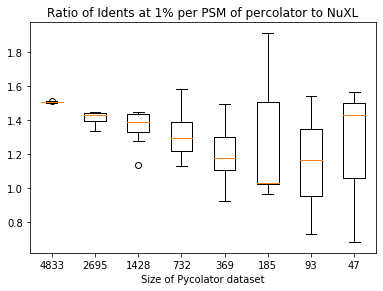

In [19]:
x = range(1,max(pAbort) + 1)

# Because the df lengths do not match, calculate metric per PSM
oriAUCNormNorm = [[a/l for a,l in zip(aucs,ls)] for aucs,ls in zip(oriAUCNorm,oriLenNorm)]
pAUCNorm = [[a/l for a,l in zip(aucs,ls)] for aucs,ls in zip(pAUCs,pLen)]
oriIdentsNormNorm = [[i/l for i,l in zip(ids,ls)] for ids,ls in zip(oriIdentsNorm,oriLenNorm)]
pIdentsNorm = [[i/l for i,l in zip(ids,ls)] for ids,ls in zip(pIdents,pLen)]

# for every sample round, for every dataset size, divide percolator result by original result
ratioAUCs = [[p/o if (o != 0) else np.nan for p,o in zip(ps,os)] for ps,os in zip(pAUCNorm,oriAUCNormNorm)]
ratioIdents = [[p/o if (o != 0) else np.nan for p,o in zip(ps,os)] for ps,os in zip(pIdentsNorm,oriIdentsNormNorm)]

# for missing iterations, fill in nan
for k in ratioAUCs:
    while(len(k) != max(pAbort)):
        k.append(np.nan)
for k in ratioIdents:
    while(len(k) != max(pAbort)):
        k.append(np.nan)
        
# transpose for boxplots
yAUC = list(map(list, zip(*ratioAUCs)))
yIdents = list(map(list, zip(*ratioIdents)))

# remove nan for boxplot
yAUC = [[i for i in ls if not np.isnan(i)] for ls in yAUC]
yIdents = [[i for i in ls if not np.isnan(i)] for ls in yIdents]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.boxplot(yAUC)
ax.set_xlabel('Size of Pycolator dataset')
ax.set_title('Ratio of AUC per PSM of percolator to NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/auc_p_vs_ori.png')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.boxplot(yIdents)
ax.set_xlabel('Size of Pycolator dataset')
ax.set_title('Ratio of Idents at 1% per PSM of percolator to NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/idents_p_vs_ori.png')
plt.show()

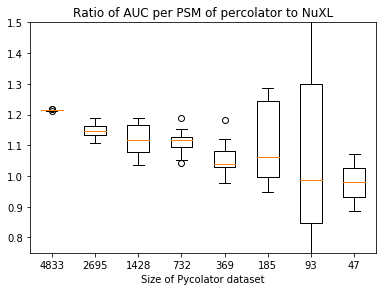

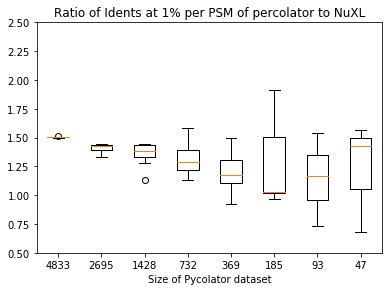

In [21]:
# Zoom into the plots

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.boxplot(yAUC)
ax.set_ylim(0.75,1.5)
ax.set_xlabel('Size of Pycolator dataset')
ax.set_title('Ratio of AUC per PSM of percolator to NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/auc_p_vs_ori_zoomed.png')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.boxplot(yIdents)
ax.set_ylim(0.5,2.5)
ax.set_xlabel('Size of Pycolator dataset')
ax.set_title('Ratio of Idents at 1% per PSM of percolator to NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/idents_p_vs_ori_zoomed.png')
plt.show()